In [1]:
import healpy as hp
import numpy as np
import math
import pandas as pd
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from scipy.special import erf

import copy
import sys
from my_units import * 

from angular_fn import *
from template_fn import *
from cov_matrix_fn import *

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


'''plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors

rcParams['mathtext.rm'] = 'Computer Modern'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
'''

HomeDir = './'
DataDir = HomeDir #+ 'code/'
### Set this to the directory where you store your data files (see below how to download them)
ListDir = HomeDir+'lists/hist_stats/'
FigDir = HomeDir+'figures/'

# Read in Files

In [2]:
df_back = pd.read_csv(DataDir+'pairs_background_ruwe_w_st.csv', usecols = ['ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'pmra_eff_error', 'pmdec_eff_error', 'pmra_pmdec_eff_corr', 'parallax', 'parallax_error', 'parallax_sub', 'parallax_eff_error', 'pmra_sub', 'pmdec_sub', 'ecl_lon', 'ecl_lat', 'l', 'b', 'ruwe'])
print('Backgrounds read in.')

df_fore = pd.read_csv(DataDir+'pairs_foreground_ruwe_w_st.csv', usecols = ['ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'ecl_lon', 'ecl_lat', 'l', 'b', 'ruwe'])
print('Foregrounds read in.')

Backgrounds read in.
Foregrounds read in.


In [3]:
max_ruwe = 1000

df_fore = df_fore[df_back['ruwe'] < max_ruwe]
df_back = df_back[df_back['ruwe'] < max_ruwe]

df_back = df_back[df_fore['ruwe'] < max_ruwe]
df_fore = df_fore[df_fore['ruwe'] < max_ruwe]

print(len(df_fore))

61138843


### Separate into different bins; this allows some cushioning so fg and bg don't mix.

In [99]:
bg_par_cut = 1.1
fg_par_cut = 1.33

df_fore = df_fore[df_back['parallax'] + 1 * df_back['parallax_error'] < bg_par_cut]
df_back = df_back[df_back['parallax'] + 1 * df_back['parallax_error'] < bg_par_cut]

df_back = df_back[df_fore['parallax'] - 1 * df_fore['parallax_error'] > fg_par_cut]
df_fore = df_fore[df_fore['parallax'] - 1 * df_fore['parallax_error'] > fg_par_cut]

In [100]:
print(len(df_fore))

12632581


# Clean Data

In [101]:
#tighten or relax cutoff
nsig_parallax = 2

In [102]:
#number of bad stars
print('Number of bad bg: ' + str(len(df_back[df_back['parallax'] + nsig_parallax*df_back['parallax_eff_error'] < 0]))); sys.stdout.flush()

Number of bad bg: 0


In [103]:
len(df_back)

12632581

In [104]:
df_fore = df_fore[df_back['parallax'] + nsig_parallax*df_back['parallax_eff_error'] >= 0]
df_back = df_back[df_back['parallax'] + nsig_parallax*df_back['parallax_eff_error'] >= 0]

In [105]:
print(len(df_fore))

12632581


In [106]:
print('Number of bad fg: ' + str(len(df_fore[df_fore['parallax']<=0]))); sys.stdout.flush()

Number of bad fg: 0


In [107]:
df_back = df_back[df_fore['parallax']> 0]
df_fore = df_fore[df_fore['parallax']> 0]
len(df_back)

12632581

## Taking into account background motion: 

In [108]:
### Functions for the lens-induced proper motion, parallax and acceleration.

### !!!!! NOTICE that the functions below take into account the finite distance of the background source as well (in the magnitude of the lensing and in the relative velocity between the source and the lens). For background stars that have a negative parallax measurement and or compatible with zero at 2-3*sigma, the coefficient (1-bg_parallax/fg_parallax) should probably be discrded.

def fn_lensing_pm(fg_ra, fg_dec, fg_pmra, fg_pmdec, fg_parallax, bg_ra, bg_dec, bg_pmra, bg_pmdec, bg_parallax, tau_obs, matched_filter=fn_dipole_mf):
    """
    Computes the lens-induced proper motion on background stars due to the foreground stars. In the template regime, the impact parameter must be larger than the distance travelled by the lens during the observation time tau_obs.    
    Output: list of 2d proper motion vectors (in mas/y) and indices of pairs with impact parameter in the template regime (the other pairs should be discarded).
    """
    l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
    l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
    l_bilhat = np.array([l_bilvec[:, 0]/np.sqrt(l_bilnormsq), l_bilvec[:, 1]/np.sqrt(l_bilnormsq)]).T 
    l_muvec = np.array([fg_pmra - bg_pmra, fg_pmdec - bg_pmdec]).T*mas/Year
    #l_muvec = np.array([fg_pmra, fg_pmdec]).T*mas/Year
    l_munorm = np.sqrt(l_muvec[:, 0]**2 + l_muvec[:, 1]**2)
    l_muhat = np.array([l_muvec[:, 0]/l_munorm, l_muvec[:, 1]/l_munorm]).T 
    l_Dl = 1/fg_parallax*kpc

    ### Evaluating the matched filter
    l_dipole_vec = matched_filter(l_muhat, l_bilhat)
    
    '''pm_list = np.array([-4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 0], 
                        -4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 1]]).T'''


    pm_list = np.array([-(1-bg_parallax/fg_parallax)*4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 0], 
                        -(1-bg_parallax/fg_parallax)*4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 1]]).T

    return pm_list[l_bilnormsq > (l_munorm*tau_obs)**2]/(mas/Year), np.arange(len(fg_ra))[l_bilnormsq > (l_munorm*tau_obs)**2]

In [109]:
def fn_tau_mu(df_fore, df_back, weights, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=True):
    """
    For a given data frame of foreground and background stars, return the proper motion tau test statistic and its normalization.
    Weights must be an array of 2x2 matrices of the same lenght of df_fore and df_back, e.g. the pm inverse covariance matrix for each background star.
    If tau_max!=False, only the values of tau < tau_max are kept in the sum over all pairs. 
    """
    
    if not quiet: print('Computing the expected velocity.'); sys.stdout.flush()
    lensing_pm, good_bil_ind = fn_lensing_pm(df_fore['ra'].to_numpy(), df_fore['dec'].to_numpy(),
                                             df_fore['pmra'].to_numpy(),  df_fore['pmdec'].to_numpy(), df_fore['parallax'].to_numpy(),
                                             df_back['ra'].to_numpy(), df_back['dec'].to_numpy(),
                                             df_back['pmra'].to_numpy(), df_back['pmdec'].to_numpy(), df_back['parallax'].to_numpy(), tau_obs, matched_filter)

    if(len(lensing_pm) < len(df_back)):
        if not quiet: print((len(df_back)-len(lensing_pm)), 'star pairs have too small impact parameter. Selecting only the good pairs.'); sys.stdout.flush()
        df_back = df_back.iloc[good_bil_ind]; weights = weights[good_bil_ind]
    
    if rot_angle:
        if not quiet: print('Rotating the dipole profile by', rot_angle/degree, 'deg'); sys.stdout.flush()
        costh, sinth = np.cos(rot_angle), np.sin(rot_angle)
        lensing_pm = np.array([lensing_pm[:,0]*costh-lensing_pm[:,1]*sinth, lensing_pm[:,1]*costh+lensing_pm[:,0]*sinth]).T


    if not quiet: print('Computing the tau lists.'); sys.stdout.flush()
    ### Observed background stars' proper motion (after subtraction)
    observed_pm = np.array([df_back['pmra_sub'].to_numpy(), df_back['pmdec_sub'].to_numpy()]).T
    tau_norm_sq = weights[:, 0, 0]*lensing_pm[:, 0]**2 + weights[:, 1, 1]*lensing_pm[:, 1]**2 + 2*weights[:, 0, 1]*lensing_pm[:, 0]*lensing_pm[:, 1]
    tau_mu = (weights[:, 0, 0]*lensing_pm[:, 0]*observed_pm[:, 0] + weights[:, 1, 1]*lensing_pm[:, 1]*observed_pm[:, 1] + 
              weights[:, 0, 1]*(lensing_pm[:, 0]*observed_pm[:, 1] + lensing_pm[:, 1]*observed_pm[:, 0]))

    if not quiet: print('Computing the sum.'); sys.stdout.flush()
    if tau_max!=0:
        small_tau_mu = tau_mu[np.abs(tau_mu) < tau_max]
        if not quiet: print(str((1-len(small_tau_mu)/len(tau_mu))*100)+'% of taus removed')
        return sum(small_tau_mu), np.sqrt(sum(tau_norm_sq[np.abs(tau_mu) < tau_max]))
    else:
        return sum(tau_mu), np.sqrt(sum(tau_norm_sq))
    

# Outlier Removal

In [110]:
npairs = len(df_fore); npairs
print('Number of pairs: ' + str(npairs)); sys.stdout.flush()

Number of pairs: 12632581


In [111]:
### Computing tau proper motion
tau_obs = 2.833*Year
### Computing the weights
inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back))  
obs_pm =  np.array([df_back['pmra_sub'].to_numpy(), df_back['pmdec_sub'].to_numpy()]).T

In [112]:
n_sigma = 3

mu_over_sigma_sq = inv_cov_pm[:, 0, 0]*obs_pm[:, 0]**2 + inv_cov_pm[:, 1, 1]*obs_pm[:, 1]**2 + 2*inv_cov_pm[:, 0, 1]*obs_pm[:, 0]*obs_pm[:, 1]
print(str((len(mu_over_sigma_sq[mu_over_sigma_sq > n_sigma**2])/len(df_back))*100)[:10]); sys.stdout.flush()

0.0


In [113]:
# remove velocity outliers
df_fore = df_fore[mu_over_sigma_sq < n_sigma**2]
df_back = df_back[mu_over_sigma_sq < n_sigma**2]
print(len(df_fore)/npairs*100); sys.stdout.flush()
npairs = len(df_fore); 

print('After pm outlier removal: ' + str(npairs))

100.0
After pm outlier removal: 12632581


In [114]:
# remove parallax outliers
parallax_over_err = np.abs(df_back['parallax_sub']/df_back['parallax_eff_error'])
df_fore = df_fore[parallax_over_err < n_sigma]
df_back= df_back[parallax_over_err < n_sigma]
print(len(df_fore)/npairs*100)
npairs = len(df_fore); npairs

100.0


12632581

In [115]:
#inv_cov_pm = np.linalg.inv(covariance_pm(df_background))  
inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back))  
obs_pm =  np.array([df_back['pmra_sub'].to_numpy(), df_back['pmdec_sub'].to_numpy()]).T

In [116]:
tau_mu, tau_norm_sq = fn_tau_mu(df_fore, df_back, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=False)

Computing the expected velocity.
Computing the tau lists.
Computing the sum.


In [117]:
print('T   : ' + str(tau_mu))
print('N   : ' + str(tau_norm_sq))
print('T/N : ' + str(tau_mu/tau_norm_sq))

T   : 24.241545399167226
N   : 0.6871180607573126
T/N : 35.280029420925445


# Anisotropy Plots

In [118]:
#Modify template to return list of values
def fn_tau_mu2(df_fore, df_back, weights, tau_obs, tau_max=False, matched_filter = fn_dipole_mf, rot_angle=False, quiet=True):
    """
    For a given data frame of foreground and background stars, return the proper motion tau test statistic and its normalization.
    Weights must be an array of 2x2 matrices of the same lenght of df_fore and df_back, e.g. the pm inverse covariance matrix for each background star.
    If tau_max!=False, only the values of tau < tau_max are kept in the sum over all pairs. 
    """
    
    if not quiet: print('Computing the expected velocity.'); sys.stdout.flush()
    lensing_pm, good_bil_ind = fn_lensing_pm(df_fore['ra'].to_numpy(), df_fore['dec'].to_numpy(),
                                             df_fore['pmra'].to_numpy(),  df_fore['pmdec'].to_numpy(), df_fore['parallax'].to_numpy(),
                                             df_back['ra'].to_numpy(), df_back['dec'].to_numpy(),
                                             df_back['pmra'].to_numpy(), df_back['pmdec'].to_numpy(), df_back['parallax'].to_numpy(), tau_obs, matched_filter)

    if(len(lensing_pm) < len(df_back)):
        if not quiet: print((len(df_back)-len(lensing_pm)), 'star pairs have too small impact parameter. Selecting only the good pairs.'); sys.stdout.flush()
        df_back = df_back.iloc[good_bil_ind]; weights = weights[good_bil_ind]
    
    if rot_angle:
        if not quiet: print('Rotating the dipole profile by', rot_angle/degree, 'deg'); sys.stdout.flush()
        costh, sinth = np.cos(rot_angle), np.sin(rot_angle)
        lensing_pm = np.array([lensing_pm[:,0]*costh-lensing_pm[:,1]*sinth, lensing_pm[:,1]*costh+lensing_pm[:,0]*sinth]).T


    if not quiet: print('Computing the tau lists.'); sys.stdout.flush()
    ### Observed background stars' proper motion (after subtraction)
    observed_pm = np.array([df_back['pmra_sub'].to_numpy(), df_back['pmdec_sub'].to_numpy()]).T
    tau_norm_sq = weights[:, 0, 0]*lensing_pm[:, 0]**2 + weights[:, 1, 1]*lensing_pm[:, 1]**2 + 2*weights[:, 0, 1]*lensing_pm[:, 0]*lensing_pm[:, 1]
    tau_mu = (weights[:, 0, 0]*lensing_pm[:, 0]*observed_pm[:, 0] + weights[:, 1, 1]*lensing_pm[:, 1]*observed_pm[:, 1] + 
              weights[:, 0, 1]*(lensing_pm[:, 0]*observed_pm[:, 1] + lensing_pm[:, 1]*observed_pm[:, 0]))

    if not quiet: print('Computing the sum.'); sys.stdout.flush()
    if tau_max!=0:
        small_tau_mu = tau_mu[np.abs(tau_mu) < tau_max]
        if not quiet: print(str((1-len(small_tau_mu)/len(tau_mu))*100)+'% of taus removed')
        return sum(small_tau_mu), np.sqrt(sum(tau_norm_sq[np.abs(tau_mu) < tau_max]))
    else:
        return tau_mu, np.sqrt(tau_norm_sq)

In [119]:
matched_filter=fn_dipole_mf
_, good_bil_ind = fn_lensing_pm(df_fore['ra'].to_numpy(), df_fore['dec'].to_numpy(),
                                             df_fore['pmra'].to_numpy(),  df_fore['pmdec'].to_numpy(), df_fore['parallax'].to_numpy(),
                                             df_back['ra'].to_numpy(), df_back['dec'].to_numpy(),
                                             df_back['pmra'].to_numpy(), df_back['pmdec'].to_numpy(), df_back['parallax'].to_numpy(), tau_obs, matched_filter)

In [120]:
#drop bad indices in the df
df_fore = df_fore.iloc[good_bil_ind]
df_back = df_back.iloc[good_bil_ind]

## Vector definitions

This section defines the key quantities for vizualisations, like the components of $\boldsymbol{\beta}_{i\ell}$ and $\boldsymbol{\mu}_{\mathrm{bg}}$ along the parallel/perpendicular directions of the foreground star's motion.

In [121]:
fg_ra = df_fore['ra'] 
fg_dec = df_fore['dec']
fg_pmra= df_fore['pmra'] 
fg_pmdec= df_fore['pmdec']


bg_ra = df_back['ra']
bg_dec = df_back['dec'] 
bg_pmra= df_back['pmra_sub'] 
bg_pmdec= df_back['pmdec_sub'] 

#bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)

l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
l_bilhat = np.array([l_bilvec[:, 0]/np.sqrt(l_bilnormsq), l_bilvec[:, 1]/np.sqrt(l_bilnormsq)]).T 
l_bilhatperp = np.array([-l_bilhat[:, 1], l_bilhat[:, 0]]).T

#foreground mu vectors
l_muvec = np.array([fg_pmra, fg_pmdec]).T*mas/Year
#l_muvec = np.array([fg_pmra - bg_pmra, fg_pmdec - bg_pmdec]).T*mas/Year


l_munormsq = l_muvec[:, 0]**2 + l_muvec[:, 1]**2
l_muhat = np.array([l_muvec[:, 0]/np.sqrt(l_munormsq), l_muvec[:, 1]/np.sqrt(l_munormsq)]).T 
l_muhatperp = np.array([-l_muhat[:, 1], l_muhat[:, 0]]).T

#project bil onto fg mu
df_back['dotprod_bil'] = (l_bilvec[:,0]*l_muhat[:,0] + l_bilvec[:,1]*l_muhat[:,1])/arcsec
df_back['dotperp_bil'] = (l_bilvec[:,0]*l_muhatperp[:,0] + l_bilvec[:,1]*l_muhatperp[:,1])/arcsec

# bg's motion parallel to and perpendicular to fg's motion
df_back['mu_par'] = (bg_pmra*l_muhat[:,0] + bg_pmdec*l_muhat[:,1])
df_back['mu_perp'] = (bg_pmra*l_muhatperp[:,0] + bg_pmdec*l_muhatperp[:,1])

In [122]:
inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back))
l_tau_mu, l_tau_mu_norm  = fn_tau_mu2(df_fore, df_back, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=False)

df_back['tau_mu_n'] = l_tau_mu/l_tau_mu_norm

Computing the expected velocity.
Computing the tau lists.
Computing the sum.


## Check the variance, then compute signal after cutting out inner stars

In [129]:
direction = df_back['mu_par']

bil_bins = np.arange(0.4, 3., 0.05)
dist_list = np.sqrt(l_bilnormsq)/arcsec
b_list = np.digitize(dist_list, bil_bins)

var = np.zeros(len(bil_bins))

for i_b in tqdm(range(len(bil_bins))):
    direction_i_b = direction[b_list == i_b]
    var[i_b] = np.var(direction_i_b) 

for i in range(len(bil_bins)):
    print(bil_bins[i], var[i])

100%|██████████| 52/52 [00:02<00:00, 23.24it/s]

0.4 21.253435075659358
0.45 15.187299619596299
0.5 15.854396598165367
0.55 12.389788774420765
0.6 10.815850922207735
0.6499999999999999 9.633527015549063
0.7 8.769186754638818
0.75 8.645794600099764
0.7999999999999999 7.735075799553642
0.8499999999999999 7.2003390353101056
0.8999999999999999 7.049735446892821
0.9499999999999998 6.877326877710333
0.9999999999999999 6.899467247254138
1.0499999999999998 6.946858391998443
1.0999999999999999 6.818600900105164
1.15 6.828543582163387
1.1999999999999997 6.69454924998504
1.25 6.669889359197526
1.2999999999999998 6.601119728328469
1.3499999999999996 6.544446856540513
1.4 6.495403060289807
1.4499999999999997 6.508508135066219
1.4999999999999996 6.554086235223318
1.5499999999999998 6.553851916781633
1.5999999999999996 6.619681119976022
1.65 6.537284784171792
1.6999999999999997 6.571845456692207
1.7499999999999996 6.540479585346902
1.7999999999999998 6.517885178370845
1.8499999999999996 6.566488382807849
1.8999999999999995 6.555288183257437
1.94999

In [136]:
cutoff_tau = 5
min_radius = 1.2 # usually around 1 arcsec

condition1 = np.abs(l_tau_mu/l_tau_mu_norm) < cutoff_tau
condition2 = np.sqrt(l_bilnormsq)/arcsec > min_radius

df_backsmaller = df_back[condition1 & condition2]
df_foresmaller = df_fore[condition1 & condition2]
l_bilnormsq_smaller = l_bilnormsq[condition1 & condition2]
len(df_backsmaller)

11716002

In [137]:
inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_backsmaller))
tau_mu, tau_norm_sq = fn_tau_mu(df_foresmaller, df_backsmaller, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=False)

Computing the expected velocity.
Computing the tau lists.
Computing the sum.


In [138]:
print('T   : ' + str(tau_mu))
print('N   : ' + str(tau_norm_sq))
print('T/N : ' + str(tau_mu/tau_norm_sq))

T   : 0.4302807536010777
N   : 0.4964389830464986
T/N : 0.8667344191235196


In [139]:
#del df_back; del df_fore

## Anisotropy (unit $\mu$)

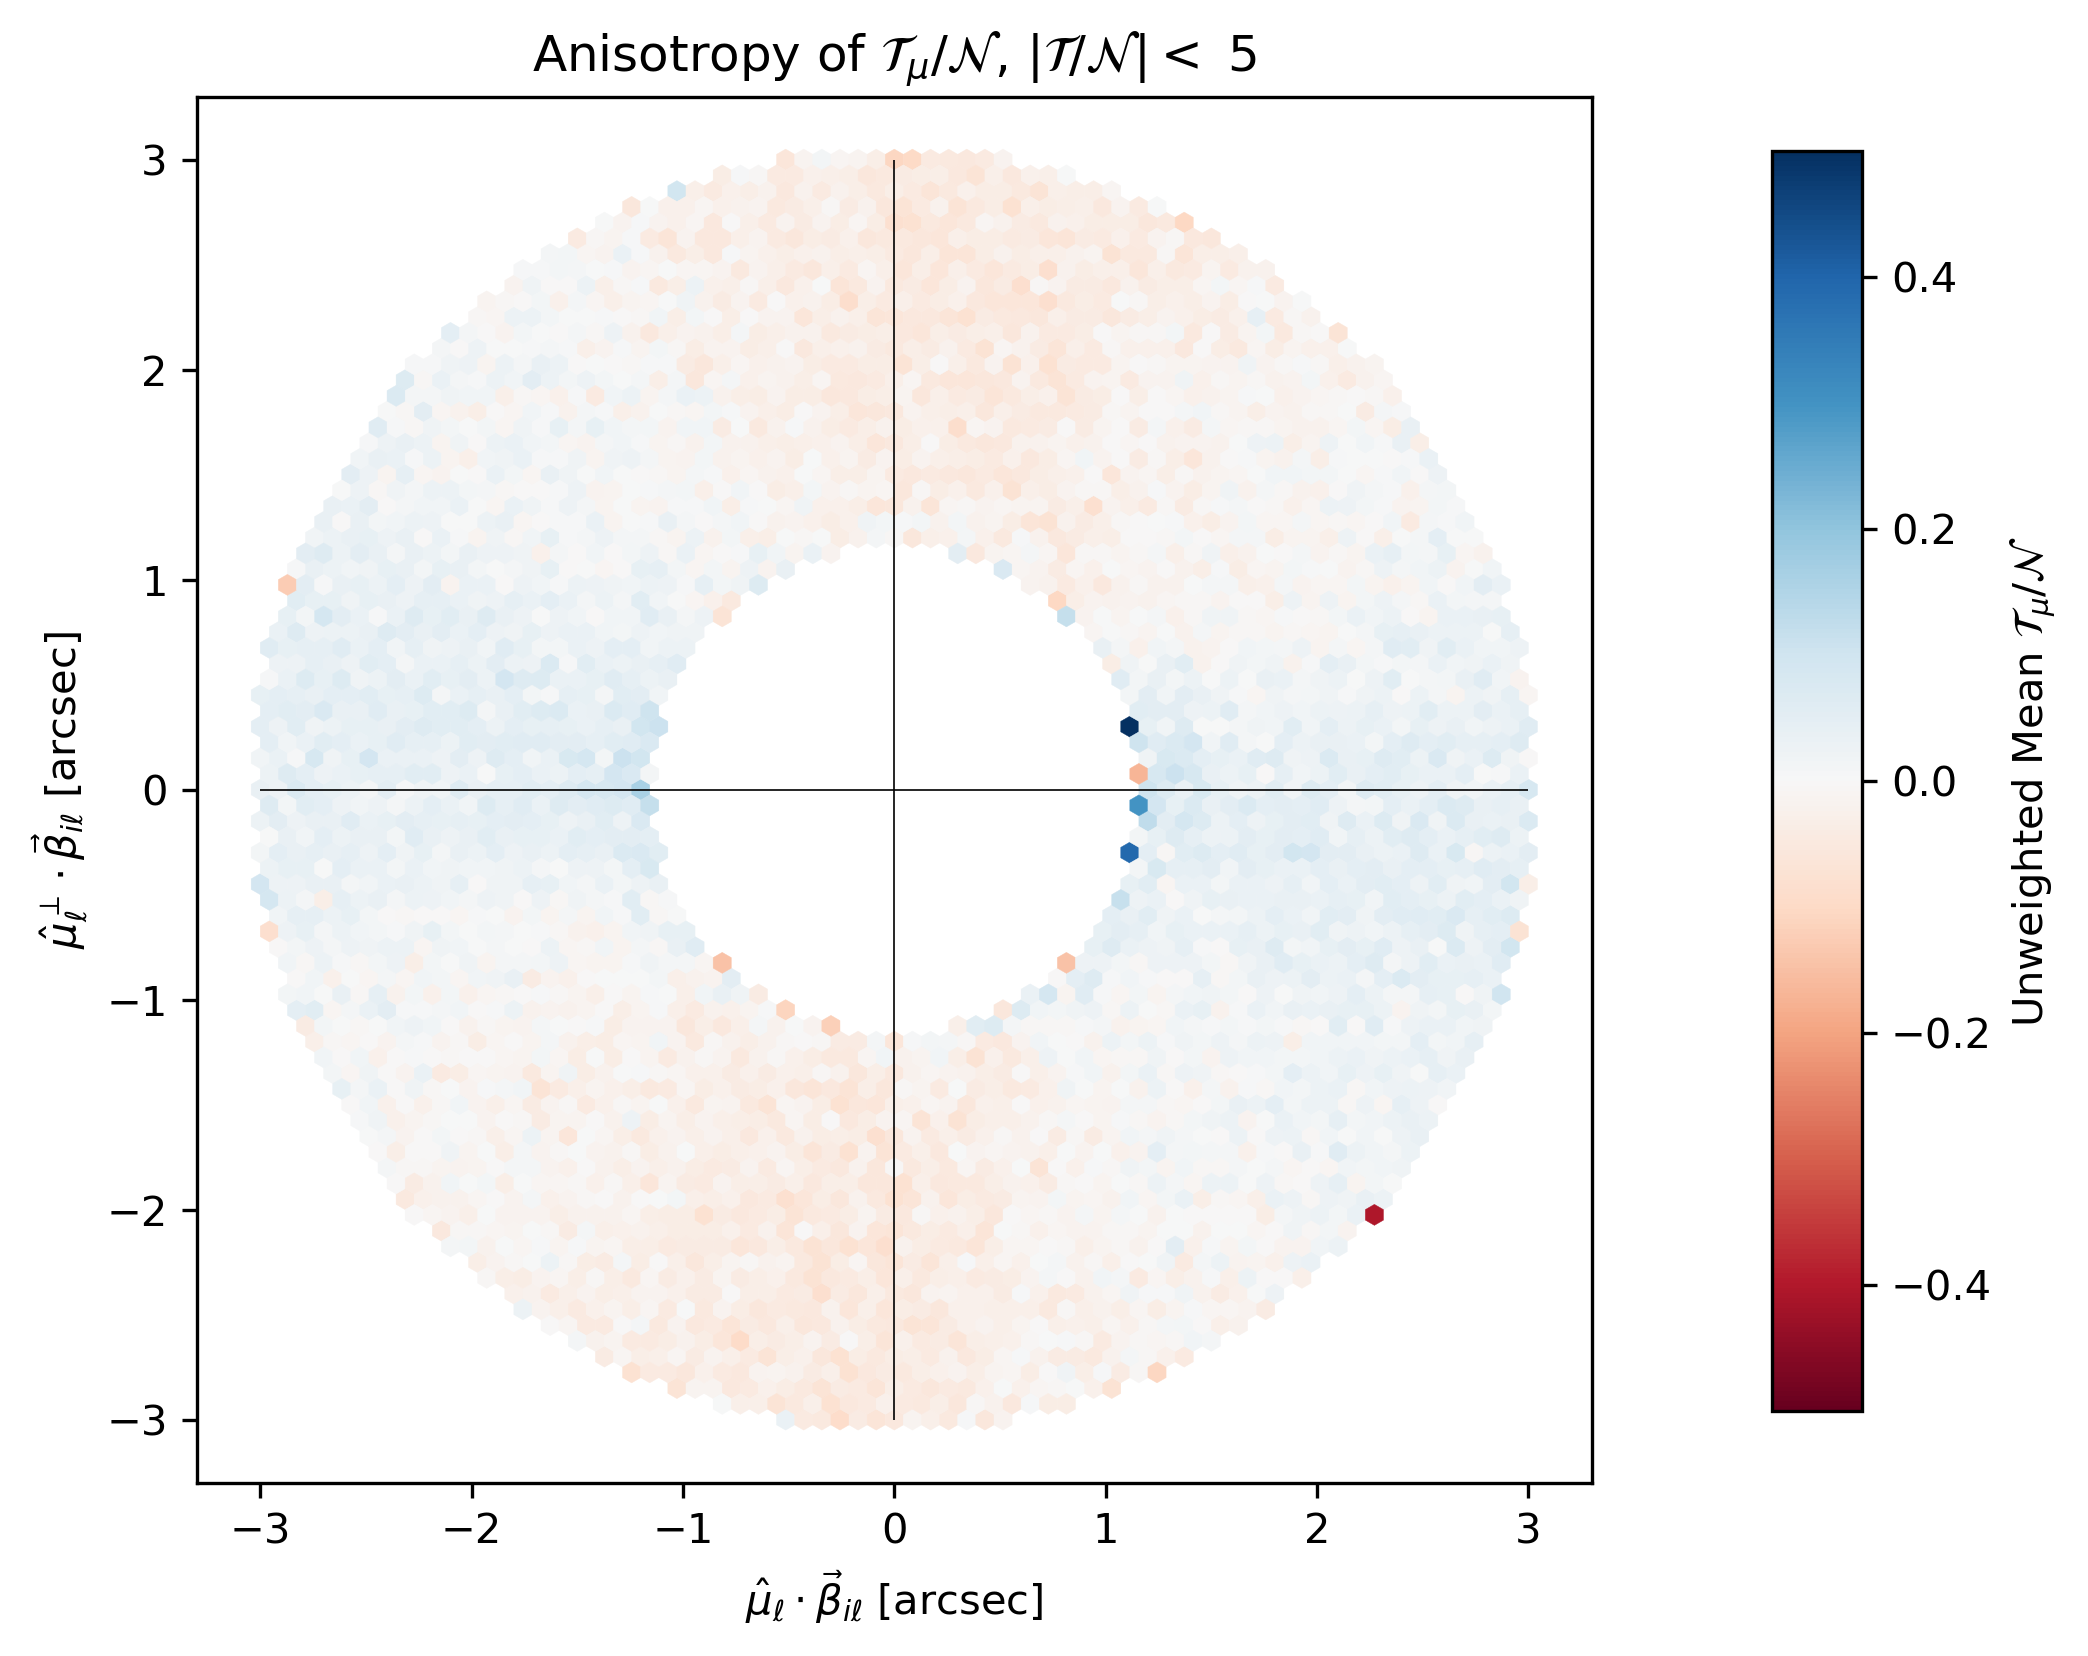

In [135]:
fig, ax = plt.subplots(1,1, figsize=(6,6),dpi=300)

im1 = ax.hexbin(x=df_backsmaller['dotprod_bil'], y=df_backsmaller['dotperp_bil'], C=df_backsmaller['tau_mu_n'], 
                reduce_C_function = np.mean, 
                vmin = - 0.1* cutoff_tau, vmax = 0.1 * cutoff_tau, 
                gridsize = 70, 
                cmap = 'RdBu',linewidths=0.1)

ax.hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax.vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)

ax.set_ylabel(r'$\hat{\mu}_{\ell}^{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax.set_xlabel(r'$\hat{\mu}_{\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax.set_title(r'Anisotropy of $\mathcal{T}_\mu/\mathcal{N}$, $|\mathcal{T}/\mathcal{N}|<$ ' + str(cutoff_tau))


#cbar_ax1 = fig.add_axes([-.05, 0.15, 0.05, 0.7])
cbar_ax1 = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)

cbar1.set_label(r'Unweighted Mean $\mathcal{T}_\mu/\mathcal{N}$')
#cbar2.set_label(r'Mean fg $\varpi/\sigma_\varpi$')

#fig.savefig('anisotropy_plot_tmu.pdf')

# Proper motion distributions

In [144]:
fg_pm_mag = np.sqrt(df_foresmaller['pmra']**2 + df_foresmaller['pmdec']**2)
bg_pm_mag = np.sqrt(df_backsmaller['pmra_sub']**2 + df_backsmaller['pmdec_sub']**2)

fg_parallax = np.asarray(df_foresmaller['parallax'])

In [145]:
fg_pm_error = np.sqrt(df_foresmaller['pmra_error']**2 + df_foresmaller['pmdec_error']**2)
bg_pm_error = np.sqrt(df_backsmaller['pmra_error']**2 + df_backsmaller['pmdec_error']**2)

In [146]:
mu_min = 0
mu_max = 10000

condition = (fg_pm_mag < mu_max) & (fg_pm_mag > mu_min)
df_back1 =  df_backsmaller[condition]
df_fore1 =  df_foresmaller[condition]
l_bilnormsq1 = l_bilnormsq_smaller[condition]

fg_pm_mag1 = np.sqrt(df_fore1['pmra']**2 + df_fore1['pmdec']**2)
len(df_fore1)

11716002

In [147]:
cutoff_mu = 0.5

df_backfar = df_back1[np.sqrt(l_bilnormsq1)/arcsec > 1.5]
far_mean = np.mean(df_backfar['mu_par']); print(far_mean)

0.0038221544718847803


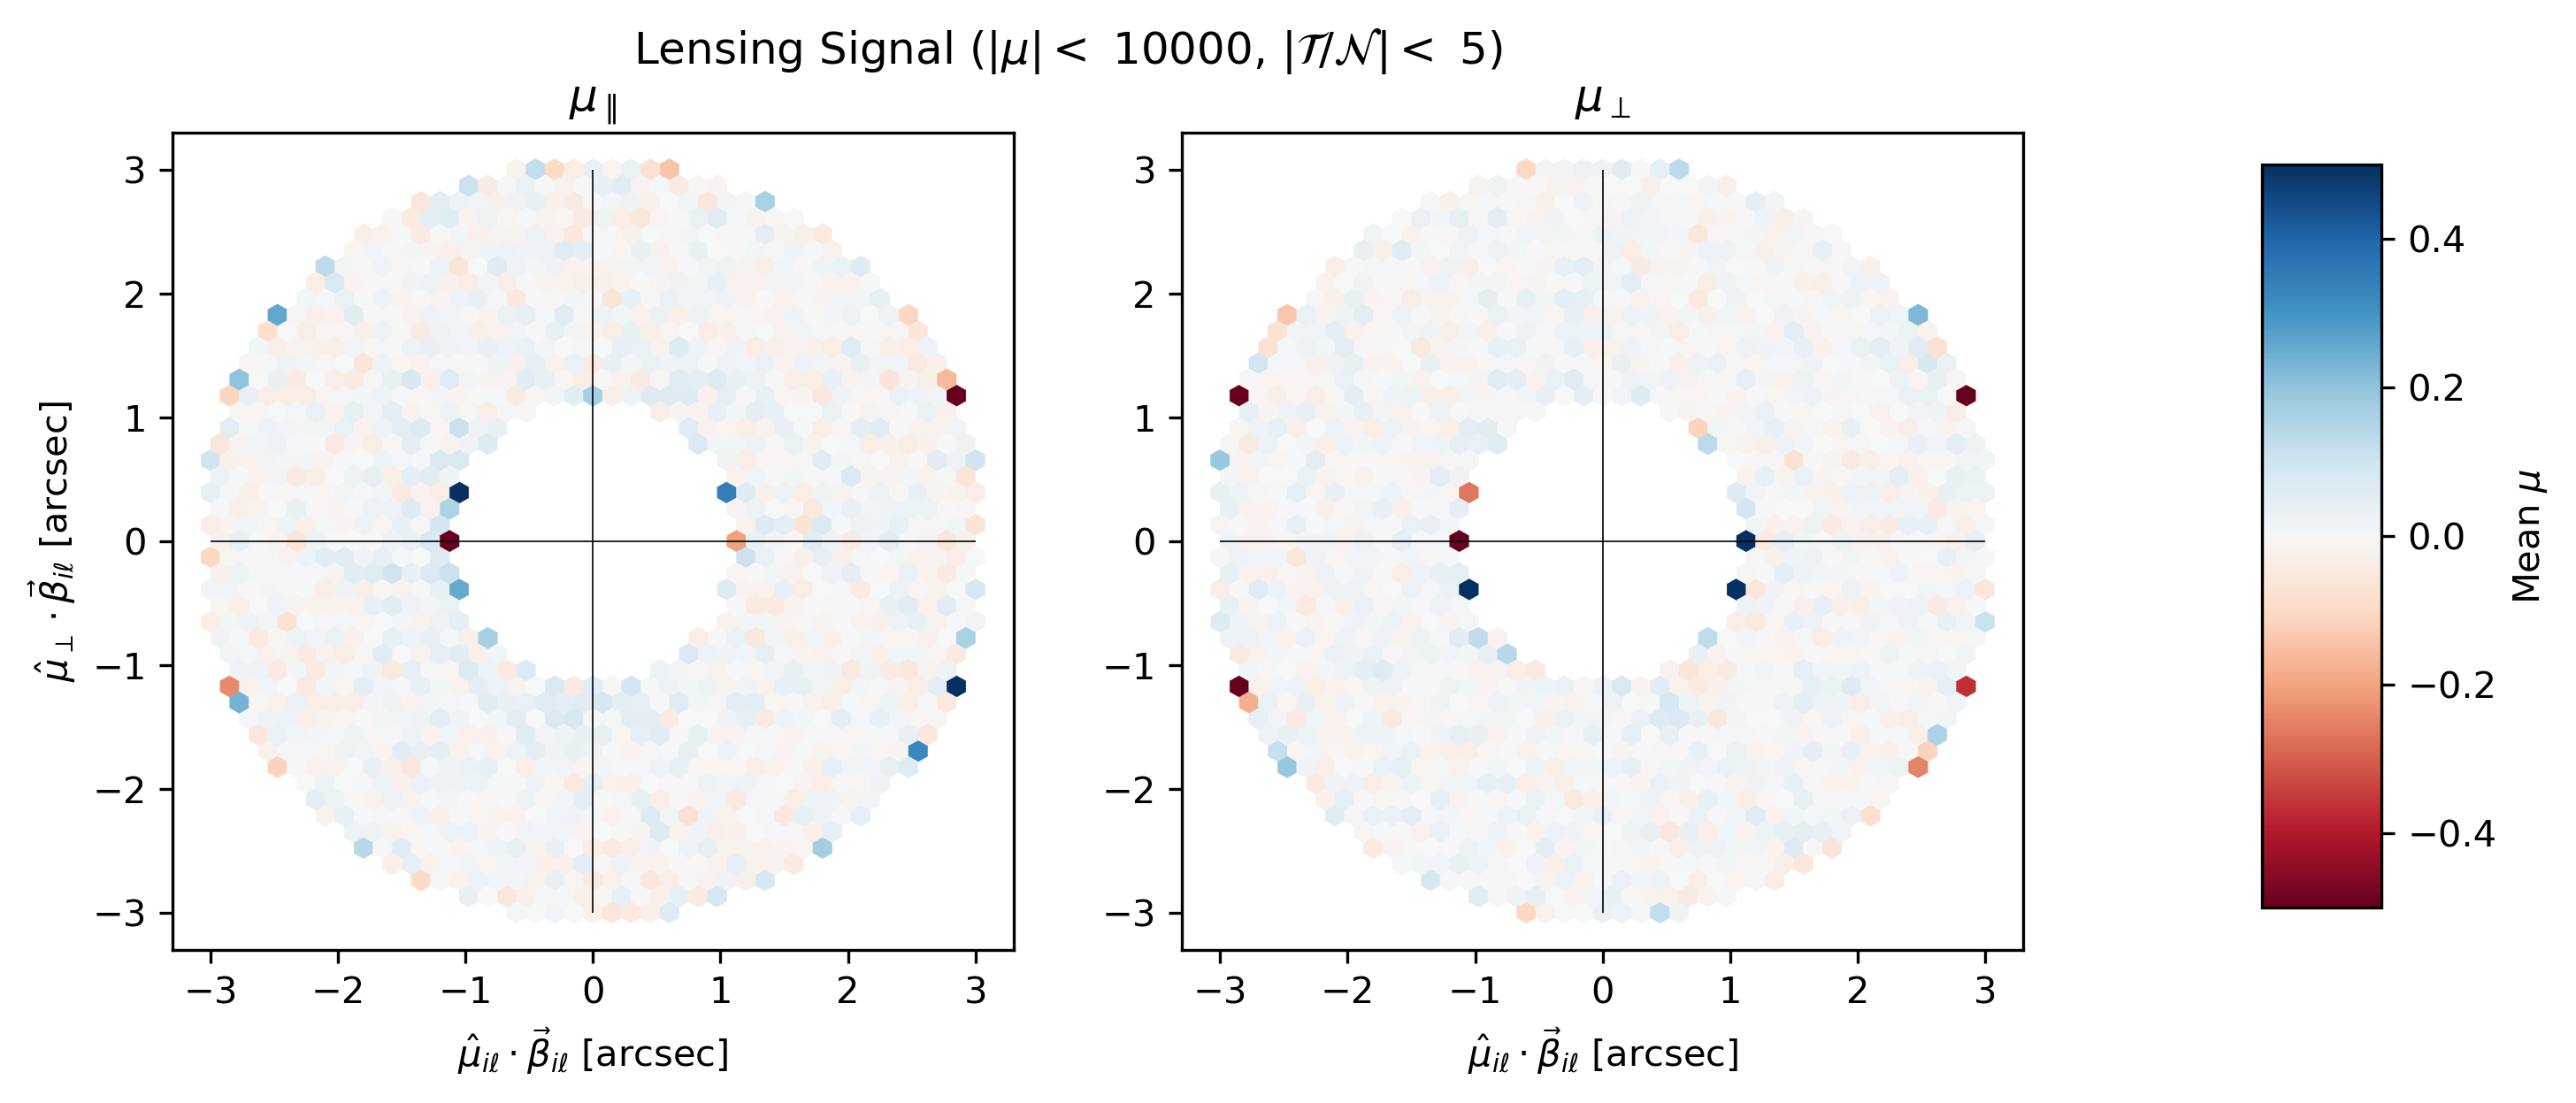

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(9,4),dpi=300)

im1 = ax[0].hexbin(x=df_back1['dotprod_bil'], y=df_back1['dotperp_bil'], C=(df_back1['mu_par']), reduce_C_function = np.mean, vmin = -cutoff_mu, vmax = cutoff_mu, gridsize=40, cmap = 'RdBu',linewidths=0.1)
ax[0].set_ylabel(r'$\hat{\mu}_{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[0].set_xlabel(r'$\hat{\mu}_{i\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[0].set_title(r'$\mu_\parallel$')

ax[0].hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax[0].vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4);

#cbar_ax1 = fig.add_axes([-.05, 0.15, 0.05, 0.7])
cbar_ax1 = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)


cbar1.set_label(r'Mean $\mu$')
#cbar2.set_label(r'Mean fg $\varpi/\sigma_\varpi$')


im2 = ax[1].hexbin(x=df_back1['dotprod_bil'], y=df_back1['dotperp_bil'], C=(np.asarray(df_back1['mu_perp'])), reduce_C_function = np.mean, vmin = -cutoff_mu, vmax = cutoff_mu, gridsize=40, cmap = 'RdBu',linewidths=0.1)
#ax[1].set_ylabel(r'$\hat{\mu}_{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[1].set_xlabel(r'$\hat{\mu}_{i\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[1].set_title(r'$\mu_\perp$')

ax[1].hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax[1].vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)

#cbar_ax1 = fig.add_axes([-.05, 0.15, 0.05, 0.7])
#cbar_ax2 = fig.add_axes([1, 0.15, 0.05, 0.7])
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)


cbar1.set_label(r'Mean $\mu$')
#cbar2.set_label(r'Mean fg $\varpi/\sigma_\varpi$')
fig.suptitle(r'Lensing Signal ($|\mu| <$ ' + str(mu_max) + r', $|\mathcal{T}/\mathcal{N}| <$ ' + str(cutoff_tau) + ')')
fig.show()
#fig.savefig('lensing_signal.pdf')

## Mean PM in radial bins

In [148]:
### Impact parameter and unit vector in the direction of the impact parameter
b_il = fn_angular_sep(df_fore['ra'].to_numpy()*degree, df_fore['dec'].to_numpy()*degree, 
                      df_back['ra'].to_numpy()*degree, df_back['dec'].to_numpy()*degree)
b_il_norm = np.sqrt(b_il[:, 0]**2 + b_il[:, 1]**2)


bil_bins = np.arange(0.5, 3., 0.3)
print(bil_bins)

dist_list = b_il_norm/arcsec; print(dist_list)
b_list = np.digitize(dist_list, bil_bins); np.bincount(b_list)

[0.5 0.8 1.1 1.4 1.7 2.  2.3 2.6 2.9]
[2.28992809 2.32941852 2.66040109 ... 2.16848257 2.44449081 2.3257122 ]


array([   3249,  174721,  504223,  799566, 1346271, 1767130, 2106269,
       2365302, 2628157,  937693])

In [149]:
mean_parallel = np.zeros(len(bil_bins))
mean_perp = np.zeros(len(bil_bins))

errbars = np.zeros(len(bil_bins))

mu_par = df_back['mu_par'].values
mu_perp = df_back['mu_perp'].values

pmra_eff_err = df_back['pmra_eff_error'].values
pmdec_eff_err = df_back['pmdec_eff_error'].values

In [150]:
for i_b in tqdm(range(len(bil_bins))):
    mu_par_i_b = mu_par[b_list == i_b]
    mu_perp_i_b = mu_perp[b_list == i_b]

    pmra_eff_err_i_b = pmra_eff_err[b_list == i_b]
    pmdec_eff_err_i_b = pmdec_eff_err[b_list == i_b]

    # weights
    d_wt = np.asarray(1/(pmra_eff_err_i_b**2 + pmdec_eff_err_i_b**2))
    ebar = np.sqrt((1/len(d_wt)**2) * np.sum(1/d_wt))


    # compute averages
    mean_par_i_b = np.average(mu_par_i_b, weights = d_wt)
    mean_perp_i_b = np.average(mu_perp_i_b, weights = d_wt)

    mean_parallel[i_b] = mean_par_i_b
    mean_perp[i_b] = mean_perp_i_b
    errbars[i_b] = ebar

100%|██████████| 9/9 [00:01<00:00,  4.65it/s]


In [151]:
mean_parallel

array([ 0.2736861 ,  0.00906121, -0.00989686, -0.00528215,  0.00032616,
        0.00082587, -0.00068737, -0.00218676, -0.00298355])

In [152]:
mean_perp

array([0.12888132, 0.03608693, 0.01438044, 0.00713001, 0.00266368,
       0.00104475, 0.00236561, 0.00147688, 0.00116338])

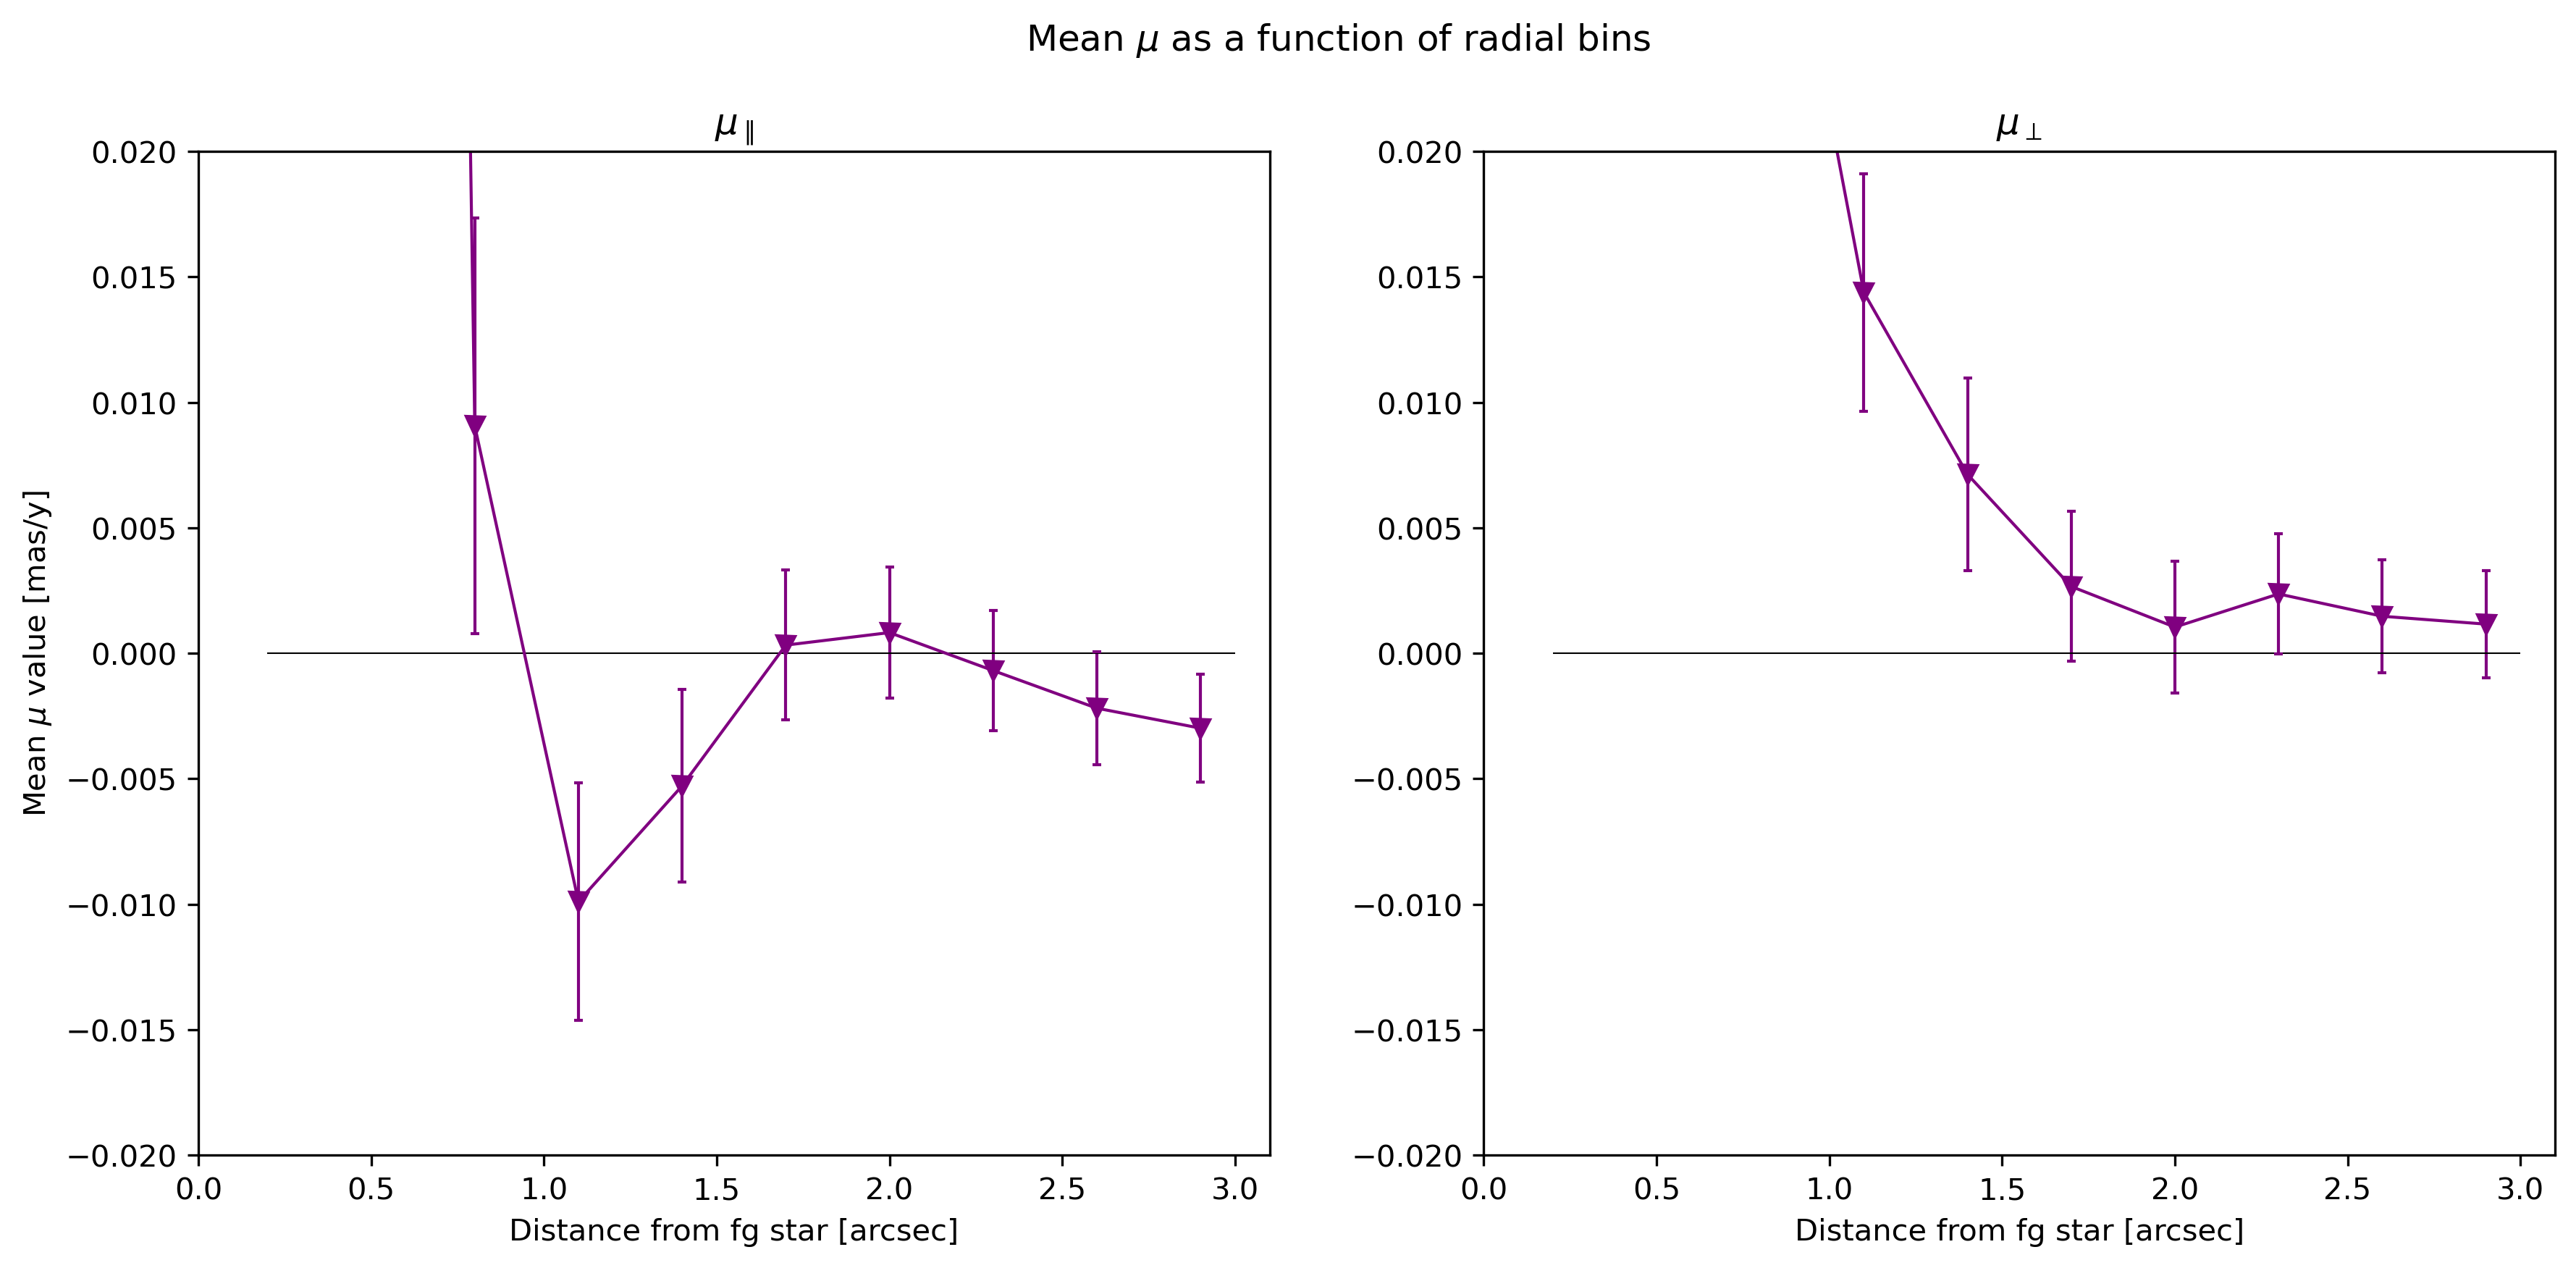

In [153]:
fig, ax = plt.subplots(1,2, figsize=(14,6),dpi=300)
ax[0].errorbar(bil_bins, mean_parallel, yerr = errbars, marker = 'v', label = 'Measured', color = 'purple', 
            elinewidth= 1, capsize = 1.5,
            lw= 1)

ax[0].set_ylabel(r'Mean $\mu$ value [mas/y]')
ax[0].set_xlabel(r'Distance from fg star [arcsec]')
ax[0].set_title(r'$\mu_\parallel$')


#ax[0].legend()
ax[0].hlines(0, 0.2, 3, colors='k', linestyles='solid', linewidth=0.5) 
ax[0].set_xlim(0, 3.1)
ax[0].set_ylim(-0.02,0.02)

ax[1].errorbar(bil_bins, mean_perp, yerr = errbars, marker = 'v', label = 'Measured', color = 'purple', 
            elinewidth= 1, capsize = 1.5,
            lw= 1)

ax[1].set_xlabel(r'Distance from fg star [arcsec]')
ax[1].set_title(r'$\mu_\perp$')

#ax[1].legend()
ax[1].hlines(0, 0.2, 3, colors='k', linestyles='solid', linewidth=0.5) 
ax[1].set_xlim(0, 3.1)
ax[1].set_ylim(-0.02,0.02)
fig.suptitle(r'Mean $\mu$ as a function of radial bins')
fig.show()

# G-magnitude dependence

In [154]:
G_bins = np.array([5, 15, 16, 17, 17.5, 17.9, 18.3, 18.6, 18.8, 18.95, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.72, 22])
q_G = np.digitize(df_foresmaller['phot_g_mean_mag'], G_bins)-1
df_foresmaller['q_G'] = q_G
df_backsmaller['q_G'] = q_G
print(G_bins[q_G])

[15.   18.95 17.5  ... 20.5  17.   17.  ]


/tmp/ipykernel_2717705/1644630271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foresmaller['q_G'] = q_G
/tmp/ipykernel_2717705/1644630271.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backsmaller['q_G'] = q_G


In [155]:
G_count = np.bincount(df_foresmaller['q_G'])
print(len(G_count), len(G_bins), sum(G_count))

28 28 11716002


In [156]:
df_foreground = df_foresmaller.sort_values(by=['q_G'], ascending=True)
df_background = df_backsmaller.sort_values(by=['q_G'], ascending=True)
df_foreground['q_G']

52099849     0
33173531     0
3546488      0
48836004     0
33173468     0
            ..
2823924     27
51309076    27
27629620    27
51307866    27
49762413    27
Name: q_G, Length: 11716002, dtype: int64

In [157]:
tau_mu_list, tau_norm_list = np.zeros(len(G_count)), np.zeros(len(G_count))
tau_rot90_list, tau_norm_rot90_list = np.zeros(len(G_count)), np.zeros(len(G_count))
tau_monopole_list, tau_norm_monopole_list = np.zeros(len(G_count)), np.zeros(len(G_count))
tau_quad_list, tau_norm_quad_list = np.zeros(len(G_count)), np.zeros(len(G_count))
gmag_mean = np.zeros(len(G_count))

last = 0
for i in tqdm(range(len(G_count))):
    df_fore_sub = df_foreground.iloc[last:last+G_count[i]] 
    df_back_sub = df_background.iloc[last:last+G_count[i]]
    last += G_count[i]
    
    gmag_mean[i] = np.mean(df_fore_sub['phot_g_mean_mag'].to_numpy())
    
    inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back_sub))

    tau_mu_list[i], tau_norm_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_dipole_mf)
    tau_rot90_list[i], tau_norm_rot90_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_dipole_mf, rot_angle=90*degree)
    tau_monopole_list[i], tau_norm_monopole_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_monopole_mf)
    tau_quad_list[i], tau_norm_quad_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_quadrupole_mf)
        
    del df_fore_sub
    del df_back_sub
print(last)

100%|██████████| 28/28 [00:37<00:00,  1.34s/it]

11716002


In [158]:
tau_mu_list/tau_norm_list

array([-3.6029316 , -0.94395304,  0.6810826 ,  1.32922148,  0.9851818 ,
       -1.11182273, -0.44707824,  1.93863616,  0.79260881,  1.17933852,
        1.64747026,  2.39831281,  1.19001778,  1.65776876,  0.09504879,
        3.23346738,  1.93144142,  2.06659651,  1.07132459,  2.14303051,
        2.06460826,  3.67916502,  0.32175469,  0.44326426,  2.08125174,
        1.40627231,  1.40157958,  0.56011771])

In [159]:
tau_monopole_list/tau_norm_monopole_list

array([-0.8898736 ,  0.53768732,  0.43944909,  2.55561009,  1.02240271,
        0.8831402 ,  1.4426378 ,  0.81052787, -0.89292846,  1.87263172,
        0.66714897,  1.05176184, -0.92175856, -0.15125365, -0.44568964,
       -0.25690061,  2.03960814,  0.65800582,  0.72761154,  1.70139725,
        1.0854369 ,  0.45740285,  0.07273932,  1.13632924,  0.71673016,
        0.86782269, -1.33816287,  1.11767908])

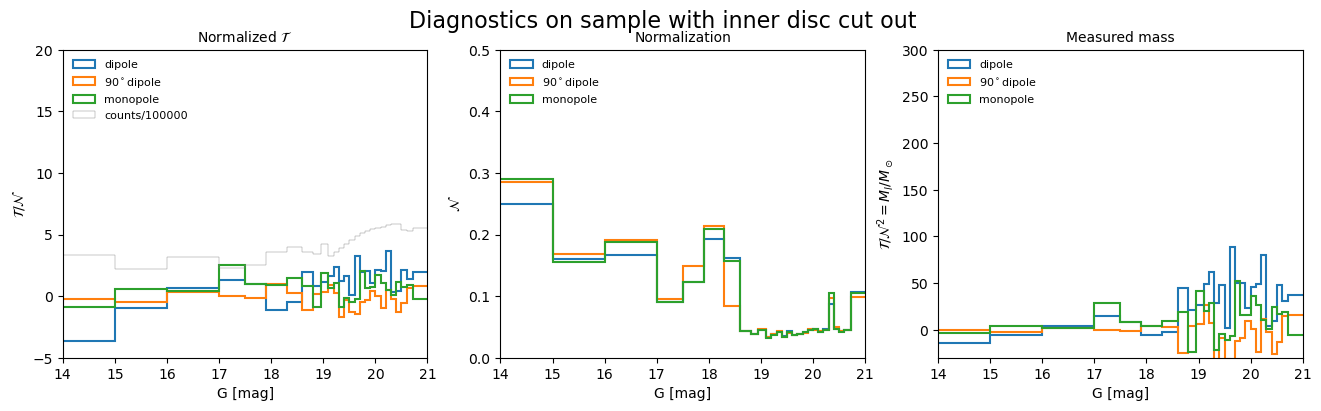

In [160]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

ax[0].hist(G_bins, bins=G_bins, weights=tau_mu_list/tau_norm_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(G_bins, bins=G_bins, weights=tau_rot90_list/tau_norm_rot90_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(G_bins, bins=G_bins, weights=tau_monopole_list/tau_norm_monopole_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(G_bins, bins=G_bins, weights=G_count/100000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[0].set_xlim(14,21); ax[0].set_ylim(-5,20);

ax[0].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/100000'], loc='upper left', fontsize = 8, frameon=False);
ax[0].set_ylabel(r'$\mathcal{T}/\mathcal{N} $'); ax[0].set_xlabel('G [mag]');
ax[0].set_title(r'Normalized $\mathcal{T}$', fontsize = 10);

ax[1].hist(G_bins, bins=G_bins, weights=tau_norm_list, log=False, histtype='step', linewidth=1.5);
ax[1].hist(G_bins, bins=G_bins, weights=tau_norm_rot90_list, log=False, histtype='step', linewidth=1.5);
ax[1].hist(G_bins, bins=G_bins, weights=tau_norm_monopole_list, log=False, histtype='step', linewidth=1.5);
#ax[1].hist(G_bins[:-1], bins=G_bins, weights=G_count/50000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[1].set_xlim(14,21); ax[1].set_ylim(0,0.5);
ax[1].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/($5\times 10^4$)'], loc='upper left', fontsize = 8, frameon=False);
ax[1].set_ylabel(r'$\mathcal{N}$'); ax[1].set_xlabel('G [mag]');
ax[1].set_title(r'Normalization', fontsize = 10);

ax[2].hist(G_bins, bins=G_bins, weights=tau_mu_list/tau_norm_list**2, log=False, histtype='step', linewidth=1.5);
ax[2].hist(G_bins, bins=G_bins, weights=tau_rot90_list/tau_norm_rot90_list**2, log=False, histtype='step', linewidth=1.5);
ax[2].hist(G_bins, bins=G_bins, weights=tau_monopole_list/tau_norm_monopole_list**2, log=False, histtype='step', linewidth=1.5);
#ax[2].hist(G_bins[:-1], bins=G_bins, weights=G_count/1000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[2].set_xlim(14,21); ax[2].set_ylim(-30,300);

ax[2].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/200'], loc='upper left', fontsize = 8, frameon=False);
ax[2].set_ylabel(r'$\mathcal{T}/\mathcal{N}^2 = M_l/M_\odot $'); ax[2].set_xlabel('G [mag]');
ax[2].set_title(r'Measured mass', fontsize = 10);

#plt.tight_layout()
fig.suptitle(r'Diagnostics on sample with inner disc cut out', fontsize = 16)
fig.show()
#fig.savefig(FigDir+'tau_vs_gmag.pdf')

In [ ]:
G_bins

array([ 5.  , 15.  , 16.  , 17.  , 17.5 , 17.9 , 18.3 , 18.6 , 18.8 ,
       18.95, 19.1 , 19.2 , 19.3 , 19.4 , 19.5 , 19.6 , 19.7 , 19.8 ,
       19.9 , 20.  , 20.1 , 20.2 , 20.3 , 20.4 , 20.5 , 20.6 , 20.72,
       22.  ])

# Impact param anisotropy

In [ ]:
foregrounds = df_foresmaller
backgrounds = df_backsmaller

In [ ]:
### Impact parameter and unit vector in the direction of the impact parameter
b_il = fn_angular_sep(foregrounds['ra'].to_numpy()*degree, foregrounds['dec'].to_numpy()*degree, 
                      backgrounds['ra'].to_numpy()*degree, backgrounds['dec'].to_numpy()*degree)
b_il_norm = np.sqrt(b_il[:, 0]**2+b_il[:, 1]**2)
b_il_hat = np.array([b_il[:, 0]/b_il_norm, b_il[:, 1]/b_il_norm]).T 

In [ ]:
### Lens velocity unit vector
#vl_vec = np.array([foregrounds['pmra'].to_numpy() - backgrounds['pmra'].to_numpy() , foregrounds['pmdec'].to_numpy() - backgrounds['pmdec'].to_numpy()]).T

#vl_vec = np.array([foregrounds['pmra'].to_numpy() - backgrounds['pmra_sub'].to_numpy() , foregrounds['pmdec'].to_numpy() - backgrounds['pmdec_sub'].to_numpy()]).T
#vl_vec = np.array([fg_pmra - bg_pmra, fg_pmdec - bg_pmdec]).T*mas/Year
vl_vec = np.array([foregrounds['pmra'].to_numpy() , foregrounds['pmdec'].to_numpy()]).T

vl_norm = np.sqrt(vl_vec[:, 0]**2 + vl_vec[:, 1]**2)
vl_hat = np.array([vl_vec[:, 0]/vl_norm, vl_vec[:, 1]/vl_norm]).T 

In [ ]:
### Angle between the impact parameter and the velocity unit vector
cos_theta = b_il_hat[:,0]*vl_hat[:,0] + b_il_hat[:,1]*vl_hat[:,1]
theta = np.arccos(cos_theta)

/share/apps/anaconda3/2020.07/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


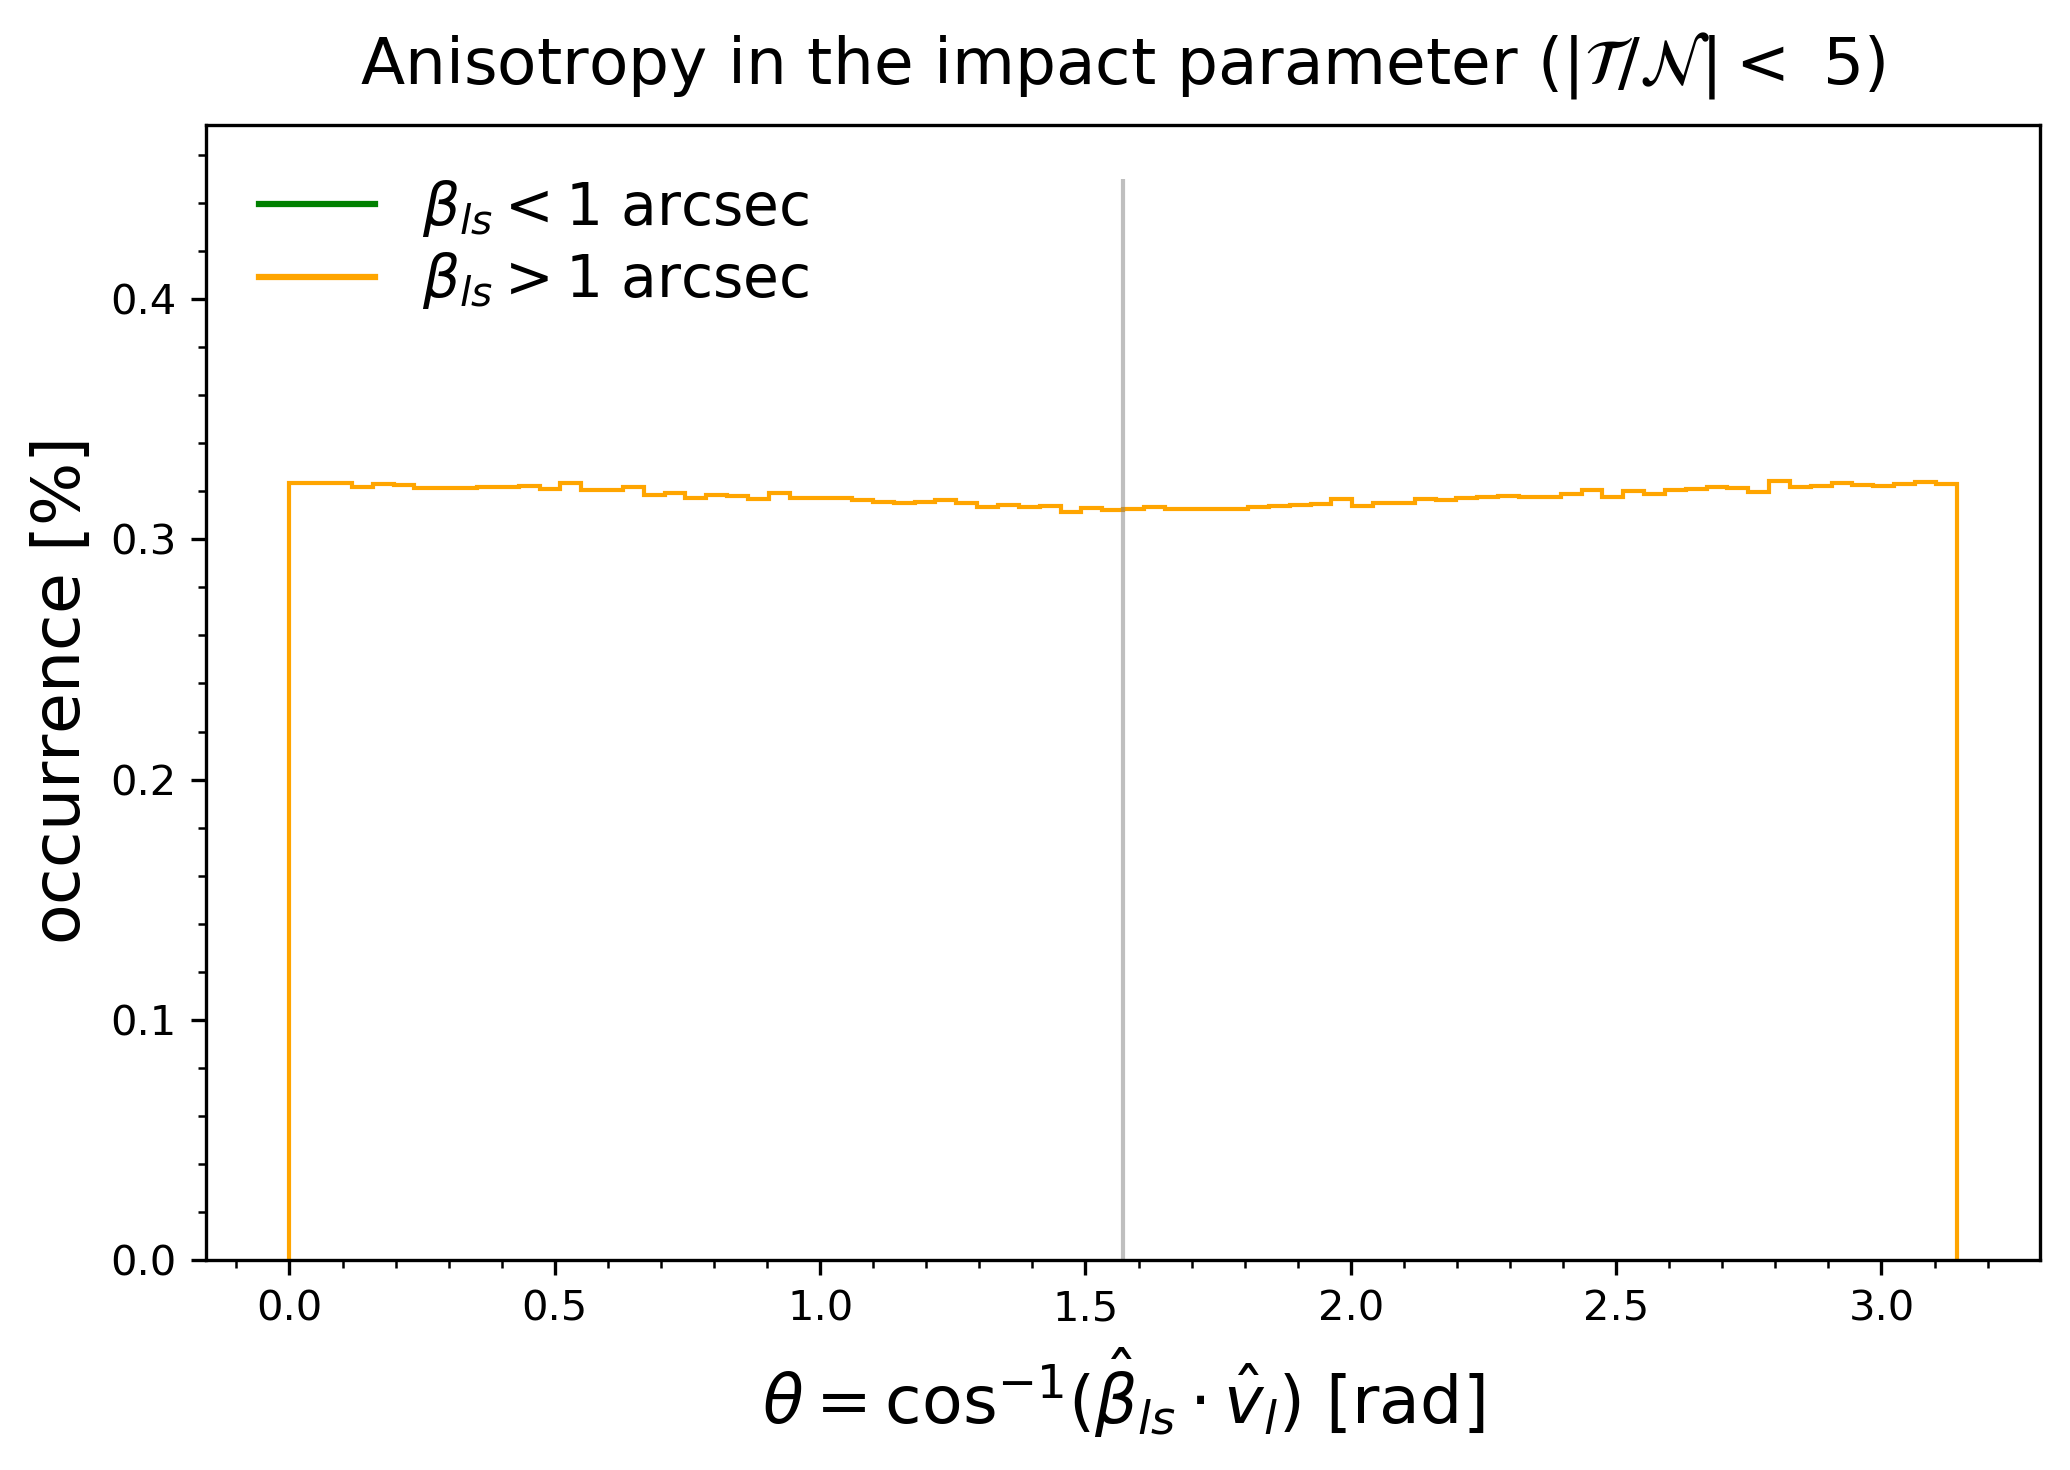

In [ ]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5), dpi=300)
colorlist = ['green', 'orange']
beta_th = 1

ax.minorticks_on()

ax.hist(theta[b_il_norm/arcsec < beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[0]);
ax.hist(theta[b_il_norm/arcsec >= beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[1]);
#ax.hist(theta[b_il_norm/arcsec >= beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[2]);
ax.set_title(r'Anisotropy in the impact parameter ($|\mathcal{T}/\mathcal{N}| <$ ' + str(cutoff_tau) + ')', pad=10, fontsize=15.5)
ax.set_xlabel(r'$\theta = \cos^{-1} (\hat{\beta}_{ls} \cdot \hat{v}_{l})$ [rad]', fontsize=16); ax.set_ylabel(r'occurrence [$\%$]', fontsize=16);

p = [plt.plot([0, 3], [0, 0], color=colorlist[i])[0] for i in range(2)] 
ax.legend(p, [r'$\beta_{ls} < '+str(beta_th)+' $ arcsec', r'$\beta_{ls} > '+str(beta_th)+' $ arcsec'], loc='upper left', frameon=False, labelspacing=0.2, fontsize=14);
[p[i].set_visible(False) for i in range(len(p))]

ax.vlines(math.pi/2, 0, 0.45, color='grey', linewidth = 1, alpha=0.5)

fig.tight_layout()
#fig.savefig(FigDir+'Impact_param_anisotropy.pdf')

In [ ]:
print(len(theta[b_il_norm/arcsec < beta_th]), len(theta[b_il_norm/arcsec >= beta_th])); sys.stdout.flush()

0 12202225
